In [1]:
# Import all dependencies
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import RidgeClassifierCV
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [4]:
# https://www.nltk.org/book/ch05.html
from nltk import word_tokenize, pos_tag

# def getPOS(part_of_speech, text):
def getPOS_noun(text):
    return sum(1 for word, pos in pos_tag(word_tokenize(text)) if pos.startswith('NN'))

def getPOS_verb(text):
    return sum(1 for word, pos in pos_tag(word_tokenize(text)) if pos.startswith('VB'))

def getPOS_adj(text):
    return sum(1 for word, pos in pos_tag(word_tokenize(text)) if pos.startswith('JJ'))

def getPOS_adv(text):
    return sum(1 for word, pos in pos_tag(word_tokenize(text)) if pos.startswith('RB'))

def getPOS_num(text):
    return sum(1 for word, pos in pos_tag(word_tokenize(text)) if pos.startswith('NUM'))

def getPOS_other(text):
    return sum(1 for word, pos in pos_tag(word_tokenize(text)) if pos.startswith('X'))

def getPOS_toBe(text):
    return sum(1 for word, pos in pos_tag(word_tokenize(text)) if pos.startswith('BE'))


### Function for feature building and extraction on natural language data

In [5]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
                   
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # ---------------------- Added Features ---------------------- #
    
    lemmatizer = WordNetLemmatizer()
    
    # remove HTML tags from reviews
    movie_data['review'] = movie_data['review'].str.replace(r'<[^<>]*>', '', regex=True)
    # lemmatize the reviews
    movie_data['lemmatized_reviews'] = movie_data.review.apply(lambda x: lemmatizer.lemmatize(x))
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set

    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    
    # ---------------------- Added Features ---------------------- #
    
    # get number of sentences per review
    movie_data['sentence_n'] = movie_data['review'].apply(lambda x: len(sent_tokenize(x)))
    
    # get POS:
    movie_data['nouns'] = movie_data.review.apply(lambda x: getPOS_noun(x))
    movie_data['adjectives'] = movie_data.review.apply(lambda x: getPOS_adj(x))
    movie_data['adverbs'] = movie_data.review.apply(lambda x: getPOS_adv(x))
    movie_data['verbs'] = movie_data.review.apply(lambda x: getPOS_verb(x))
    movie_data['other'] = movie_data.review.apply(lambda x: getPOS_other(x))
    movie_data['to_be'] = movie_data.review.apply(lambda x: getPOS_toBe(x))
    
    
    # use the features:
    X_quant_features = movie_data[["word_count", "punc_count", "sentence_n", "nouns", "adjectives", "adverbs", "verbs",
                                  "other", "to_be"]]

    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

### Create training and test sets from function 
Test set is using 25

In [6]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# testing set uses 25: 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/moviereviews_train.tsv', my_random_seed=25)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))



movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

# Test models - Train set

#### MODEL: Ridge Regression Classifier

In [7]:
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


#### MODEL: Random Forest Classifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9977, 'Neg': 10023, 'TP': 6954, 'TN': 5536, 'FP': 4487, 'FN': 3023, 'Accuracy': 0.6245, 'Precision': 0.6078140022725286, 'Recall': 0.6970031071464368, 'desc': 'rdf_train'}


#### MODEL: Linear SVC


In [9]:
# LinearSVC
linear_SVC = svm.LinearSVC()
linear_SVC.fit(X_train, y_train)

linear_SVC_performance_train = BinaryClassificationPerformance(linear_SVC.predict(X_train), y_train, 
                                                               'linear_SVC_train')
linear_SVC_performance_train.compute_measures()
print(linear_SVC_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_train'}


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### ROC plot to compare performance of various models and fits - TRAIN set

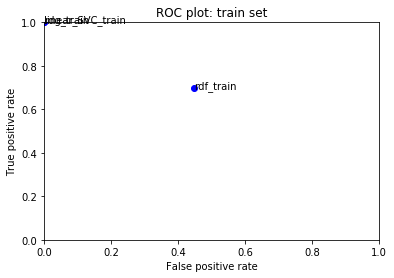

In [10]:
fits = [rdg_performance_train, rdf_performance_train, linear_SVC_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [11]:
rdg_predictions = rdg.predict(X_train)

In [12]:
# false positives
print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:


In [13]:
rdf_predictions = rdf.predict(X_train)

In [14]:
# false positives
print("Examples of false positives:")

import random, time

for i in range(0, len(rdf_predictions)):
    if (rdf_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
50
This film's trailer interested me enough to warrant renting the DVD. However, the resulting movie is absolutely dire! Admittedly, this is not the worst film ever made, or the worst film this year, but it came damn close!The main issue is the film not knowing what it wants to be: comedy, adult drama, thriller, teen-porn? The story is interesting, as it deals with the pitfalls of mail-order brides, but the film is a mess. What starts out as a mildly interesting \comedy\" (a word I use in the loosest possible terms), then goes totally in reverse, and degenerates into a very dark and distasteful misogynistic thriller. Nicole Kidman should know better, and Ben Chaplin is wasted! As are Matthieu Kassovitz and Vincent Cassel, whom I can only presume did this for the money.This is a bad film in pretty much every single aspect. It's not funny, it's almost so sexist that you could almost forgive Benny Hill for everything he did, and the dramatic elements are just 

1943
But it does have some good action and a plot that is somewhat interesting. Nevsky acts like a body builder and he isn't all that attractive, in fact, IMO, he is UGLY. ( his acting skills lack everything! ) Sascha is played very well by Joanna Pacula, but she needed more lines than she was given, her character needed to be developed. There are way too many men in this story, there is zero romance, too much action, and way too dumb of an ending. It is very violent. I did however love the scenery, this movie takes you all over the world, and that is a bonus. I also liked how it had some stuff about the mafia in it, not too much or too little, but enough that it got my attention. The actors needed to be more handsome...The biggest problem I had was that Nevsky was just too normal, not sexy enough. I think for most guys, Sascha will be hot enough, but for us ladies that are fans of action, Nevsky just doesn't cut it. Overall, this movie was fine, I didn't love it nor did I hate it, jus

3850
This movie proves that you can't judge a movie by the awesome artwork on the DVD cover. It also goes to show that you should learn more about a movie before you buy it (or get it for someone at Christmas). The beginning of this movie actually looks somewhat promising. Well, until you meet the characters. Pumpkin Jack (the old guy from down the street) brings the college co-eds a book full of witch's spells that he leaves at their annual haunted house (where the movie takes place). After that there is some drinking, fighting, and soft core porn. Then the action of the movie finally takes place after over an hour.Overall, Hallow's End was predictable, unsuspensful, and reminiscent of a soft-core porn. This movie is probably best viewed with a group of friends who have nothing better to do, as it is a good movie to make fun of. And for first-time viewers, it is really fun making predictions of the order of people who die.
* * * * * * * * * 
4003
There is just one word for this film. 

5917
Since the Little Mermaid was one of my favorite Disney movies when I was little, I was curious about its sequel.The Little Mermaid(one) is a classic animated feature with top quality everything, a grand music score, and targets a general audience. In contrast, the Little Mermaid 2 is targeted primarily at young children, because it is spontaneous, reflects a child's self perspective, the music is bouncier and less dramatic, and the ending feels like recess.The Little Mermaid 2 starts out when baby Melody is presented to Ariel's side of the family. Abruptly without any visual cues to aid the drama, a giant tentacle grabs the baby. I laughed, wait a minute it's not funny, the baby's being attacked! Okay, I'll stop laughing. Morgana's crime in broad daylight and her spontaneity, takes away potential drama since it happened so quickly.Throughout the feature, Melody seems superhuman, which I defend is how most children envision themselves. This quality in Melody's character is clearly 

7959
This movie was awesome!! (Not quite as good as the Leif Garrett masterpiece Longshot) but still awesome!! I thought Ashley looked freakin' huge compared to Mary-Kate in this film. I wonder why. Who woulda thought they could swith places like that and almost get away with it. Dad was kinda a jerk though and Mom was a little too chummy with Helmit Head. I give it 4. Any one who likes this movie shoudl check out Longshot.
* * * * * * * * * 
7978
I'm going to write about this movie and about \Irreversible\" (the (in)famous scene in it). So you are warned, if you haven't seen the movie yet. This are just my thoughts, why I think the movie fails (in the end - pun intended).Acting wise, Rosario Dawson is really good and almost conveys portraying someone almost a decade younger (a teenager in other words). The villain guy is good, but loses his \"evil\" touch right before the end. If he really never changes, then why would he let a woman tie him up? He wouldn't, period. Then we also have 

9951
What boob at MGM thought it would be a good idea to place the studly Clark Gable in the role of a Salvation Army worker?? Ironically enough, another handsome future star, Cary Grant, also played a Salvation Army guy just two years later in the highly overrated SHE DONE HIM WRONG. I guess in hindsight it's pretty easy to see the folly of these roles, but I still wonder WHO thought that Salvation Army guys are \HOT\" and who could look at these dashing men and see them as realistic representations of the parts they played. A long time ago, I used to work for a sister organization of the Salvation Army (the Volunteers of America) and I NEVER saw any studly guys working there (and that includes me, unfortunately). Maybe I should have gotten a job with the Salvation Army instead!So, for the extremely curious, this is a good film to look out for, but for everyone else, it's poor writing, sloppy dialog and annoying moralizing make for a very slow film."
* * * * * * * * * 
9989
The title 

11757
Typically terrible trash from director Fred Olen Ray about a female cyborg hunter(Teagan)commissioned by Warden Jan-Michael Vincent to find and execute escaped alien convict Ross Hagen who has charted course for earth. Soon Forest Ranger John Phillip Law will have to protect a group of obnoxiously hammy college kids headed by the grating Richard Wiley who ran over Hagen with his RV on a camping trip gone awry. Soon the cyborg will be blasting away with her arm laser burning one innocent alcoholic Doctor(Robert Quarry of Count Yorga-Vampire fame)proving that no one will stand in it's way of retrieving the hide of the convict, whose collar is a tracking device that weakens his body. Law finds an ally in Leo Gordon, an old Vietnam war vet with way too weapons stashed in his cabin.Perhaps intentionally made awful, this features what fans of \rancid cinema\" yearn for..dreadful special effects, acting, and premise. At least, the film has PJ Soles for some eye candy..even in '89, she w

13871
This movie is one of the worst horror movies I have ever seen. From the very first scene, i knew it would be a smash crash. It starts with a seemingly bad girl killing a bunch of nuns in a mission. As it turns out, the people in it were possessed by some random zombies. Well, some years later, some college kids are pulling some pledge prank. Horrible acting goes from pledge to the head jock. Things like the jock yelling at him to do stuff in quite a non-chalonte manner, with pledge over reacting and over-doing the whole \eager to be popular role\" What really took the cake with this one is the final battle. Absolutely HORRIBLE special effects with the guns. For example, guns making a noise with no muzzle flash, and vice-versa. this is accompanied by stop-animation zombies (why they move in stop motion is a mystery), cheesy music, and about 40 guns that come out of nowhere.Overall, this movie is crap. Just like so many others you can rent for 50 cents at your nearest low brow movi

15657
$25,000 Pyramid Clues: Deep Blue Sea. Tremors. Slither. Eight Legged Freaks.Pyramid Category: Movies that were funnier and more thrilling than Snakes on a Plane.Hell, with that definition I'd have to include the relatively harrowing journey of Ted and Elaine in Airplane! as superior to Snakes in both laughs and thrills.The sad truth is that this isn't even close to the mother of all unintentionally intentional funny snake movies: Anaconda! Besides the never to be seen again casting of JLo-Cube-O.Wilson-Stoltz-Wuhrer in the same flick, you had Jon Voight pulling off the all-time cinematic heist. His final scene alone represents everything SOAP tried and failed to do as a \so-ludicrous-it's-fun\" movie.In the end, Snakes on a Plane is definitive proof that studio execs and fanboys make the worst collaborators possible. Every big scene had been discussed and dissected so much the last year, all that was left to amuse by opening night was the amount of fanboy flop-sweat that had to b

* * * * * * * * * 
17562
I have come out of several years of lurking on these boards due to the sheer lack of intelligence that is communicated through the reviews that periodically appear on this film's IMDb space. I saw this movie courtesy of subway cinema's new york Asian film festival (which had an otherwise excellent selection of movies this year, see vital, snake of june, CHA NO AJI, Survive Style)and have regretted every day that a scene from that movie disengorges itself from the back of my mind, and becomes a vivid memory.I'm sure that you can read a laudatory summary of the film off of Subway Cinema, which is probably why I made the mistake of dragging my friend to the film. The description built up the kind of horror film that I had longed for for a while, one that relies on sheer terror rather than cheap scares. P was in fact different. It relied on cheap laughs.The incredibly annoying announcer described this movie as \Lesbians team up to fight monsters.\" Completely untru

19233
Even by 1942 standards of movie-making the setup which HER CARDBOARD LOVER presents was dated to the extreme. The machinations of one half of a pair (of husband/wife, ex-husband/ex-wife) to get the other back at the threat of marriage to another, divorce, or an eventual separation by means of jealousy, humiliation, or other schemes had been done much better in classics such as HIS GIRL Friday and THE PHILADELPHIA STORY. Both of these movies features women with a strong, indomitable screen presence and who played independent, proto-feminist characters. In both movies, both women were estranged/divorced from their (witty) first husbands and set to marry colorless men who were their exact opposite, and both would be bamboozled into rejecting their soon-to-be husbands and re-igniting their passion for each other.The plot in HER CARDBOARD LOVER switches the gender: here, it's Norma Shearer in the Cary Grant role out, this time, to ward off an ex-boyfriend (George Sanders) by means of 

# Test models - Test set

#### MODEL: Ridge Regression Classifier

In [15]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2182, 'TN': 2064, 'FP': 413, 'FN': 341, 'Accuracy': 0.8492, 'Precision': 0.8408477842003853, 'Recall': 0.8648434403487911, 'desc': 'rdg_test'}


#### MODEL: Random Forest Classifier

In [16]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1748, 'TN': 1388, 'FP': 1089, 'FN': 775, 'Accuracy': 0.6272, 'Precision': 0.6161438138879097, 'Recall': 0.6928260007927071, 'desc': 'rdf_test'}


#### MODEL: Linear SVC

In [17]:
linear_SVC_performance_test = BinaryClassificationPerformance(linear_SVC.predict(X_test), y_test, 
                                                              'linear_SVC_test')
linear_SVC_performance_test.compute_measures()
print(linear_SVC_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2099, 'FP': 378, 'FN': 310, 'Accuracy': 0.8624, 'Precision': 0.8541103820918564, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_test'}


### ROC plot to compare performance of various models and fits - TEST set

{'Pos': 2523, 'Neg': 2477, 'TP': 2182, 'TN': 2064, 'FP': 413, 'FN': 341, 'Accuracy': 0.8492, 'Precision': 0.8408477842003853, 'Recall': 0.8648434403487911, 'desc': 'rdg_test'}
{'Pos': 2523, 'Neg': 2477, 'TP': 1748, 'TN': 1388, 'FP': 1089, 'FN': 775, 'Accuracy': 0.6272, 'Precision': 0.6161438138879097, 'Recall': 0.6928260007927071, 'desc': 'rdf_test'}
{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2099, 'FP': 378, 'FN': 310, 'Accuracy': 0.8624, 'Precision': 0.8541103820918564, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_test'}


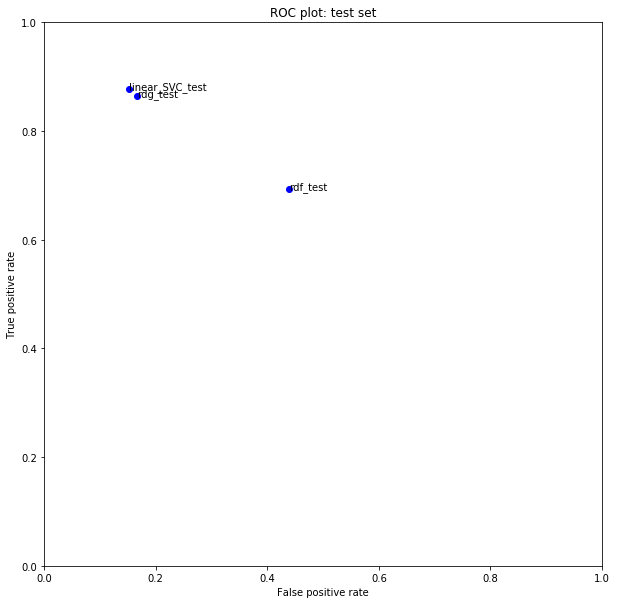

In [18]:
fits = [rdg_performance_test, rdf_performance_test, linear_SVC_performance_test]


plt.figure(figsize=(10,10))

for fit in fits:
    print(fit.performance_measures)
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


# ITERATIONS

#### MODEL: Ridge Regression Classifier

##### default

In [19]:
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


##### alpha=1000

In [20]:
rdg1000 = linear_model.RidgeClassifier(alpha=1000)
rdg1000.fit(X_train, y_train)

rdg1000_performance_train = BinaryClassificationPerformance(rdg1000.predict(X_train), y_train, 'rdg_train1000')
rdg1000_performance_train.compute_measures()
print(rdg1000_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train1000'}


##### alpha=10000000

In [21]:
rdg10000000 = linear_model.RidgeClassifier(alpha=10000000)
rdg10000000.fit(X_train, y_train)

rdg10000000_performance_train = BinaryClassificationPerformance(rdg10000000.predict(X_train), y_train, 'rdg_train10000000')
rdg10000000_performance_train.compute_measures()
print(rdg10000000_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 8362, 'TN': 9877, 'FP': 146, 'FN': 1615, 'Accuracy': 0.91195, 'Precision': 0.9828396803008933, 'Recall': 0.8381276936954997, 'desc': 'rdg_train10000000'}


##### solver='sag'

In [22]:
rdg_sag = linear_model.RidgeClassifier(solver='sag')
rdg_sag.fit(X_train, y_train)

rdg_sag_performance_train = BinaryClassificationPerformance(rdg10000000.predict(X_train), y_train, 'rdg_train_sag')
rdg_sag_performance_train.compute_measures()
print(rdg_sag_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 8362, 'TN': 9877, 'FP': 146, 'FN': 1615, 'Accuracy': 0.91195, 'Precision': 0.9828396803008933, 'Recall': 0.8381276936954997, 'desc': 'rdg_train_sag'}


##### random_state=1000

In [23]:
rdg_random_state = linear_model.RidgeClassifier(random_state=1000)
rdg_random_state.fit(X_train, y_train)

rdg_random_state_performance_train = BinaryClassificationPerformance(rdg10000000.predict(X_train), y_train, 'rdg_train_random-state')
rdg_random_state_performance_train.compute_measures()
print(rdg_random_state_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 8362, 'TN': 9877, 'FP': 146, 'FN': 1615, 'Accuracy': 0.91195, 'Precision': 0.9828396803008933, 'Recall': 0.8381276936954997, 'desc': 'rdg_train_random-state'}


##### random_state=1000, alpha=10000000

In [24]:
rdg_alpha_random = linear_model.RidgeClassifier(random_state=1000, alpha=10000000)
rdg_alpha_random.fit(X_train, y_train)

rdg_alpha_random_performance_train = BinaryClassificationPerformance(rdg_alpha_random.predict(X_train), y_train, 
                                                                     'rdg_train_alpha-random')
rdg_alpha_random_performance_train.compute_measures()
print(rdg_alpha_random_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 8359, 'TN': 9877, 'FP': 146, 'FN': 1618, 'Accuracy': 0.9118, 'Precision': 0.9828336272780718, 'Recall': 0.8378270021048412, 'desc': 'rdg_train_alpha-random'}


##### random_state=1000, alpha=1000

In [25]:

rdg_alpha_random_2 = linear_model.RidgeClassifier(random_state=1000, alpha=1000)
rdg_alpha_random_2.fit(X_train, y_train)

rdg_alpha_random_2_performance_train = BinaryClassificationPerformance(rdg_alpha_random_2.predict(X_train), y_train, 
                                                                     'rdg_train_alpha-random-2')
rdg_alpha_random_2_performance_train.compute_measures()
print(rdg_alpha_random_2_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha-random-2'}


# Linear SVC

##### default

In [26]:
# LinearSVC
linear_SVC_default = svm.LinearSVC()
linear_SVC_default.fit(X_train, y_train)

linear_SVC_default_performance_train = BinaryClassificationPerformance(linear_SVC_default.predict(X_train), y_train, 
                                                               'linear_SVC_default_train')
linear_SVC_default_performance_train.compute_measures()
print(linear_SVC_default_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_default_train'}


##### C=1000000

In [27]:
# LinearSVC
linear_SVC_1m = svm.LinearSVC(C=1000000)
linear_SVC_1m.fit(X_train, y_train)

linear_SVC_1m_performance_train = BinaryClassificationPerformance(linear_SVC_1m.predict(X_train), y_train, 
                                                               'linear_SVC_1m_train')
linear_SVC_1m_performance_train.compute_measures()
print(linear_SVC_1m_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_1m_train'}


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


##### C=0.001

In [28]:
# LinearSVC
linear_SVC_001 = svm.LinearSVC(C=0.001)
linear_SVC_001.fit(X_train, y_train)

linear_SVC_001_performance_train = BinaryClassificationPerformance(linear_SVC_001.predict(X_train), y_train, 
                                                               'linear_SVC_001_train')
linear_SVC_001_performance_train.compute_measures()
print(linear_SVC_001_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_001_train'}


##### C=1e-15

In [29]:
# LinearSVC
linear_SVC_1e15 = svm.LinearSVC(C=1e-15)
linear_SVC_1e15.fit(X_train, y_train)

linear_SVC_1e15_performance_train = BinaryClassificationPerformance(linear_SVC_1e15.predict(X_train), y_train, 
                                                               'linear_SVC_1e15_train')
linear_SVC_1e15_performance_train.compute_measures()
print(linear_SVC_1e15_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 8558, 'TN': 9816, 'FP': 207, 'FN': 1419, 'Accuracy': 0.9187, 'Precision': 0.9763833428408443, 'Recall': 0.8577728776185226, 'desc': 'linear_SVC_1e15_train'}


# Random Forest

##### max_depth=2, random_state=0, n_estimators=1000

In [30]:
from sklearn.ensemble import RandomForestClassifier
rdf1 = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=1000)
rdf1.fit(X_train, y_train)

rdf_performance_train_1 = BinaryClassificationPerformance(rdf1.predict(X_train), y_train, 'rdf1_train')
rdf_performance_train_1.compute_measures()
print(rdf_performance_train_1.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 8121, 'TN': 8461, 'FP': 1562, 'FN': 1856, 'Accuracy': 0.8291, 'Precision': 0.8386863575338221, 'Recall': 0.813972135912599, 'desc': 'rdf1_train'}


##### max_depth=2, random_state=0, n_estimators=3000

In [31]:
rdf2 = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=3000)
rdf2.fit(X_train, y_train)

rdf_performance_train_2 = BinaryClassificationPerformance(rdf2.predict(X_train), y_train, 'rdf2_train')
rdf_performance_train_2.compute_measures()
print(rdf_performance_train_2.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 8107, 'TN': 8595, 'FP': 1428, 'FN': 1870, 'Accuracy': 0.8351, 'Precision': 0.8502359727320399, 'Recall': 0.8125689084895259, 'desc': 'rdf2_train'}


##### max_depth=2, random_state=0, n_estimators=5000

In [32]:
rdf3 = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=5000)
rdf3.fit(X_train, y_train)

rdf_performance_train_3 = BinaryClassificationPerformance(rdf3.predict(X_train), y_train, 'rdf3_train')
rdf_performance_train_3.compute_measures()
print(rdf_performance_train_3.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 8186, 'TN': 8619, 'FP': 1404, 'FN': 1791, 'Accuracy': 0.84025, 'Precision': 0.8535974973931179, 'Recall': 0.8204871203768668, 'desc': 'rdf3_train'}


### ROC plot to compare performance of various models and fits - TRAIN set

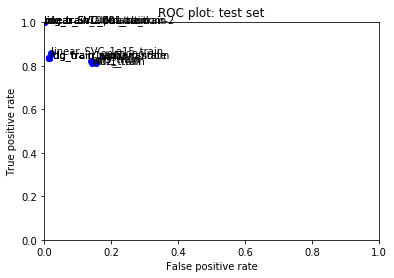

In [33]:
fits = [rdg_performance_train, rdg1000_performance_train, rdg10000000_performance_train, 
        rdg_sag_performance_train, rdg_random_state_performance_train,
        rdg_alpha_random_performance_train, rdg_alpha_random_2_performance_train,
       linear_SVC_default_performance_train, linear_SVC_1m_performance_train, 
        linear_SVC_001_performance_train, linear_SVC_1e15_performance_train,
       rdf_performance_train_1, rdf_performance_train_2, rdf_performance_train_3]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## Look at performance on the test set

#### MODEL: Ridge Regression Classifier

##### default

In [34]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2180, 'TN': 2063, 'FP': 414, 'FN': 343, 'Accuracy': 0.8486, 'Precision': 0.8404009252120278, 'Recall': 0.8640507332540627, 'desc': 'rdg_test'}


##### alpha=1000

In [35]:
rdg1000_performance_test = BinaryClassificationPerformance(rdg1000.predict(X_test), y_test, 'rdg_test_1000')
rdg1000_performance_test.compute_measures()
print(rdg1000_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2203, 'TN': 2085, 'FP': 392, 'FN': 320, 'Accuracy': 0.8576, 'Precision': 0.8489402697495183, 'Recall': 0.8731668648434403, 'desc': 'rdg_test_1000'}


##### alpha=10000000

In [36]:
rdg10000000_performance_test = BinaryClassificationPerformance(rdg10000000.predict(X_test), y_test, 'rdg_test_10000000')
rdg10000000_performance_test.compute_measures()
print(rdg10000000_performance_test.performance_measures)




{'Pos': 2523, 'Neg': 2477, 'TP': 1786, 'TN': 2327, 'FP': 150, 'FN': 737, 'Accuracy': 0.8226, 'Precision': 0.9225206611570248, 'Recall': 0.7078874355925485, 'desc': 'rdg_test_10000000'}


##### random_state=1000

In [37]:
rdg_random_state_performance_test = BinaryClassificationPerformance(rdg_random_state.predict(X_test), y_test, 'rdg_test_random-state')
rdg_random_state_performance_test.compute_measures()
print(rdg_random_state_performance_test.performance_measures)




{'Pos': 2523, 'Neg': 2477, 'TP': 2180, 'TN': 2063, 'FP': 414, 'FN': 343, 'Accuracy': 0.8486, 'Precision': 0.8404009252120278, 'Recall': 0.8640507332540627, 'desc': 'rdg_test_random-state'}


##### random_state=1000, alpha=10000000

In [38]:
rdg_alpha_random_performance_test = BinaryClassificationPerformance(rdg_alpha_random.predict(X_test), y_test, 
                                                                    'rdg_test_alpha-random')
rdg_alpha_random_performance_test.compute_measures()
print(rdg_alpha_random_performance_test.performance_measures)




{'Pos': 2523, 'Neg': 2477, 'TP': 1784, 'TN': 2327, 'FP': 150, 'FN': 739, 'Accuracy': 0.8222, 'Precision': 0.922440537745605, 'Recall': 0.7070947284978201, 'desc': 'rdg_test_alpha-random'}


##### random_state=1000, alpha=1000

In [39]:
rdg_alpha_random_2_performance_test = BinaryClassificationPerformance(rdg_alpha_random_2.predict(X_test), y_test, 
                                                                    'rdg_test_alpha-random-2')
rdg_alpha_random_2_performance_test.compute_measures()
print(rdg_alpha_random_2_performance_test.performance_measures)




{'Pos': 2523, 'Neg': 2477, 'TP': 2202, 'TN': 2083, 'FP': 394, 'FN': 321, 'Accuracy': 0.857, 'Precision': 0.8482280431432974, 'Recall': 0.8727705112960761, 'desc': 'rdg_test_alpha-random-2'}


# Linear SVC

##### default

In [40]:
linear_SVC_default_performance_test = BinaryClassificationPerformance(linear_SVC_default.predict(X_test), y_test, 
                                                              'linear_SVC_default_test')
linear_SVC_default_performance_test.compute_measures()
print(linear_SVC_default_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2099, 'FP': 378, 'FN': 310, 'Accuracy': 0.8624, 'Precision': 0.8541103820918564, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_default_test'}


##### C=1000000

In [41]:
linear_SVC_1m_performance_test = BinaryClassificationPerformance(linear_SVC_1m.predict(X_test), y_test, 
                                                              'linear_SVC_1m_test')
linear_SVC_1m_performance_test.compute_measures()
print(linear_SVC_1m_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2099, 'FP': 378, 'FN': 310, 'Accuracy': 0.8624, 'Precision': 0.8541103820918564, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_1m_test'}


##### C=0.001

In [42]:
linear_SVC_001_performance_test = BinaryClassificationPerformance(linear_SVC_001.predict(X_test), y_test, 
                                                              'linear_SVC_001_test')
linear_SVC_001_performance_test.compute_measures()
print(linear_SVC_001_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2219, 'TN': 2114, 'FP': 363, 'FN': 304, 'Accuracy': 0.8666, 'Precision': 0.8594113090627421, 'Recall': 0.8795085216012684, 'desc': 'linear_SVC_001_test'}


##### C=1e-15

In [43]:
linear_SVC_1e15_performance_test = BinaryClassificationPerformance(linear_SVC_1e15.predict(X_test), y_test, 
                                                              'linear_SVC_1e15_test')
linear_SVC_1e15_performance_test.compute_measures()
print(linear_SVC_1e15_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1871, 'TN': 2312, 'FP': 165, 'FN': 652, 'Accuracy': 0.8366, 'Precision': 0.918958742632613, 'Recall': 0.7415774871185097, 'desc': 'linear_SVC_1e15_test'}


# Random Forest

##### max_depth=2, random_state=0, n_estimators=1000

In [44]:
rdf1_performance_test = BinaryClassificationPerformance(rdf1.predict(X_test), y_test, 'rdf1_test')
rdf1_performance_test.compute_measures()
print(rdf1_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2061, 'TN': 2075, 'FP': 402, 'FN': 462, 'Accuracy': 0.8272, 'Precision': 0.8367844092570037, 'Recall': 0.816884661117717, 'desc': 'rdf1_test'}


##### max_depth=2, random_state=0, n_estimators=3000

In [45]:
rdf2_performance_test = BinaryClassificationPerformance(rdf2.predict(X_test), y_test, 'rdf2_test')
rdf2_performance_test.compute_measures()
print(rdf2_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2044, 'TN': 2109, 'FP': 368, 'FN': 479, 'Accuracy': 0.8306, 'Precision': 0.8474295190713101, 'Recall': 0.8101466508125248, 'desc': 'rdf2_test'}


##### max_depth=2, random_state=0, n_estimators=5000


In [46]:
rdf3_performance_test = BinaryClassificationPerformance(rdf3.predict(X_test), y_test, 'rdf3_test')
rdf3_performance_test.compute_measures()
print(rdf3_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2064, 'TN': 2112, 'FP': 365, 'FN': 459, 'Accuracy': 0.8352, 'Precision': 0.8497324001646768, 'Recall': 0.8180737217598097, 'desc': 'rdf3_test'}


### ROC plot to compare performance of various models and fits - TEST set

{'Pos': 2523, 'Neg': 2477, 'TP': 2180, 'TN': 2063, 'FP': 414, 'FN': 343, 'Accuracy': 0.8486, 'Precision': 0.8404009252120278, 'Recall': 0.8640507332540627, 'desc': 'rdg_test'}
{'Pos': 2523, 'Neg': 2477, 'TP': 2203, 'TN': 2085, 'FP': 392, 'FN': 320, 'Accuracy': 0.8576, 'Precision': 0.8489402697495183, 'Recall': 0.8731668648434403, 'desc': 'rdg_test_1000'}
{'Pos': 2523, 'Neg': 2477, 'TP': 1786, 'TN': 2327, 'FP': 150, 'FN': 737, 'Accuracy': 0.8226, 'Precision': 0.9225206611570248, 'Recall': 0.7078874355925485, 'desc': 'rdg_test_10000000'}
{'Pos': 2523, 'Neg': 2477, 'TP': 2180, 'TN': 2063, 'FP': 414, 'FN': 343, 'Accuracy': 0.8486, 'Precision': 0.8404009252120278, 'Recall': 0.8640507332540627, 'desc': 'rdg_test_random-state'}
{'Pos': 2523, 'Neg': 2477, 'TP': 1784, 'TN': 2327, 'FP': 150, 'FN': 739, 'Accuracy': 0.8222, 'Precision': 0.922440537745605, 'Recall': 0.7070947284978201, 'desc': 'rdg_test_alpha-random'}
{'Pos': 2523, 'Neg': 2477, 'TP': 2202, 'TN': 2083, 'FP': 394, 'FN': 321, 'Accurac

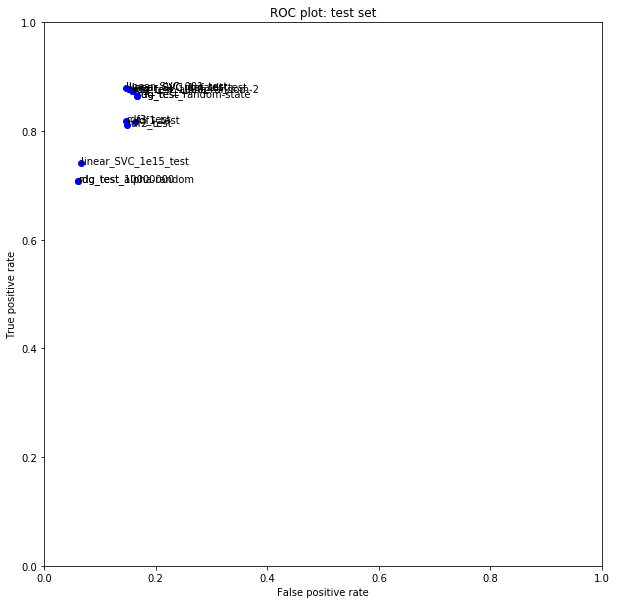

In [47]:
fits = [rdg_performance_test, rdg1000_performance_test, rdg10000000_performance_test, 
        rdg_random_state_performance_test, rdg_alpha_random_performance_test, rdg_alpha_random_2_performance_test,
       linear_SVC_default_performance_test, linear_SVC_1m_performance_test, linear_SVC_001_performance_test, 
        linear_SVC_1e15_performance_test, 
       rdf1_performance_test, rdf2_performance_test, rdf3_performance_test]

plt.figure(figsize=(10,10))

for fit in fits:
    print(fit.performance_measures)
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
